In [1]:
!pip install pycuda

In [2]:
import numpy as np
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
from PIL import Image
import matplotlib.pyplot as plt
import time


In [3]:
source_kernel="""#define BLOCK_SIZE 16
#define CHANNELS 3   // R,G,B

// Example 3x3 sharpen kernel
__constant__ float d_kernel[9] = {
     0, -1,  0,
    -1,  5, -1,
     0, -1,  0
};

// CUDA Kernel for 2D convolution with stencil, RGB image
__global__ void conv2d_rgb_stencil(
    unsigned char *input, unsigned char *output,
    int width, int height)
{
    __shared__ unsigned char tile[BLOCK_SIZE+2][BLOCK_SIZE+2][CHANNELS];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int col = blockIdx.x * BLOCK_SIZE + tx;
    int row = blockIdx.y * BLOCK_SIZE + ty;

    if (row < height && col < width) {
        for(int c = 0; c < CHANNELS; c++) {
            // Load center pixel
            tile[ty+1][tx+1][c] = input[(row*width + col)*CHANNELS + c];

            // Halo pixels
            if (tx == 0 && col > 0)
                tile[ty+1][0][c] = input[(row*width + (col-1))*CHANNELS + c];
            if (tx == BLOCK_SIZE-1 && col < width-1)
                tile[ty+1][BLOCK_SIZE+1][c] = input[(row*width + (col+1))*CHANNELS + c];
            if (ty == 0 && row > 0)
                tile[0][tx+1][c] = input[((row-1)*width + col)*CHANNELS + c];
            if (ty == BLOCK_SIZE-1 && row < height-1)
                tile[BLOCK_SIZE+1][tx+1][c] = input[((row+1)*width + col)*CHANNELS + c];
        }
    }

    __syncthreads();

    if (row < height && col < width) {
        for(int c = 0; c < CHANNELS; c++) {
            float sum = 0.0f;
            for(int ky = -1; ky <= 1; ky++) {
                for(int kx = -1; kx <= 1; kx++) {
                    int shared_x = tx + 1 + kx;
                    int shared_y = ty + 1 + ky;

                    // Clamp within tile bounds
                    shared_x = max(0, min(shared_x, BLOCK_SIZE+1));
                    shared_y = max(0, min(shared_y, BLOCK_SIZE+1));

                    float pixel = (float)tile[shared_y][shared_x][c];
                    float coeff = d_kernel[(ky+1)*3 + (kx+1)];
                    sum += pixel * coeff;
                }
            }
            sum = min(max(sum, 0.0f), 255.0f);
            output[(row*width + col)*CHANNELS + c] = (unsigned char)sum;
        }
    }
}
"""

In [6]:
print("Compiling the CUDA Kernel....")
#compile the cuda

mode =  SourceModule(source_kernel)

#Get the compiler function from the compile module
Conv2d_rgb_stencil= mode.get_function('conv2d_rgb_stencil')


print("kernel compiled successfully")

Compiling the CUDA Kernel....
kernel compiled successfully


The matrix of Bukayo Saka is now initialised


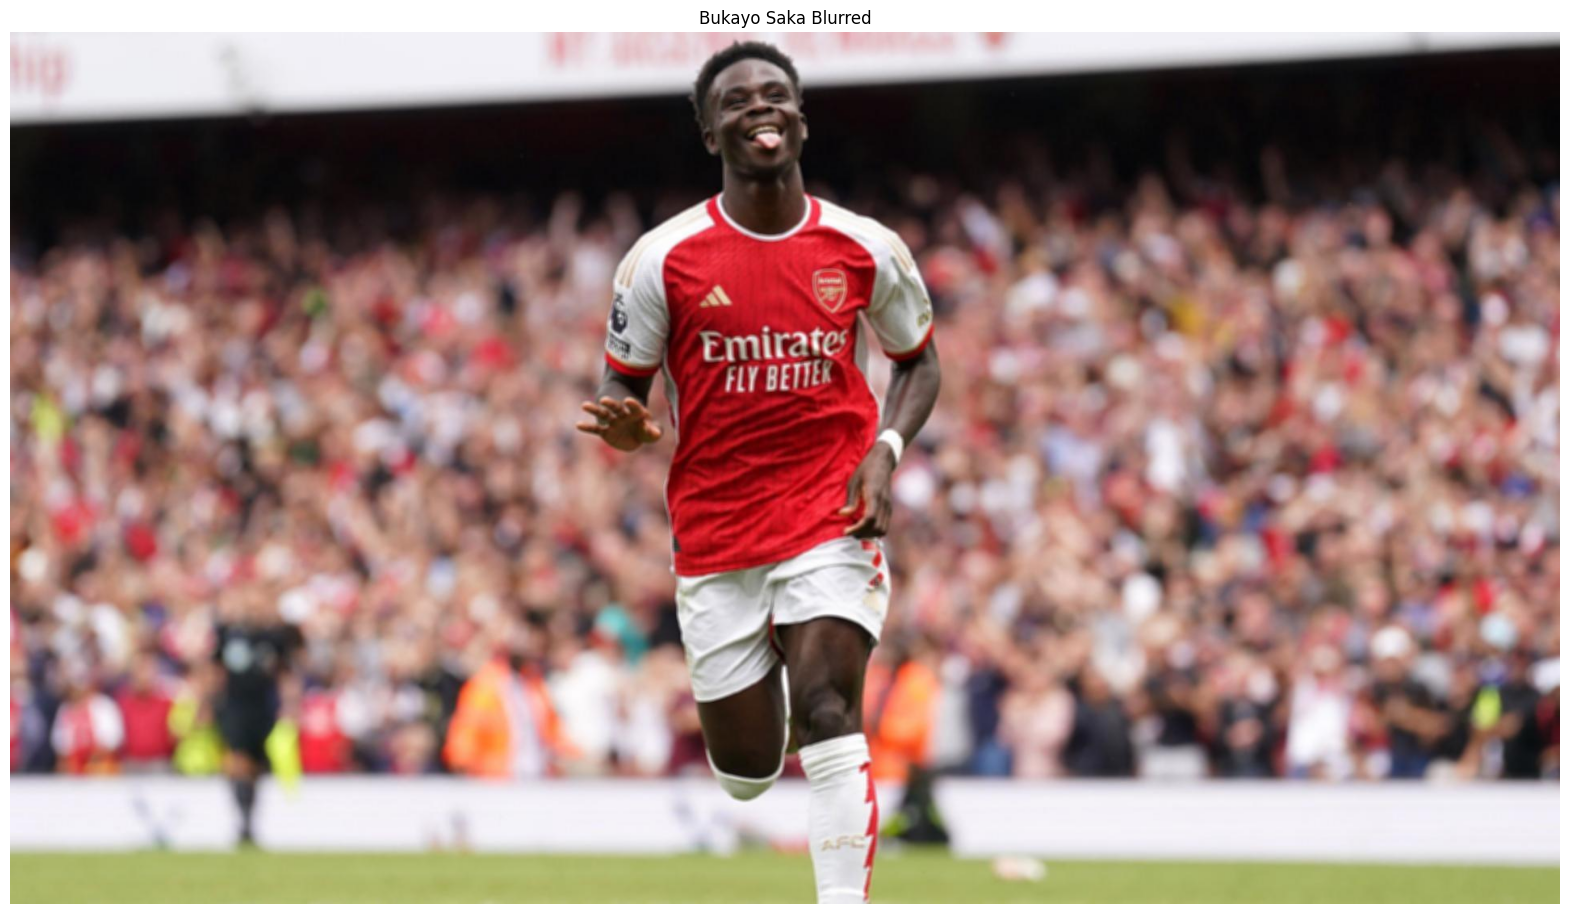

In [7]:
#Load the image
image = np.array(Image.open('saka_blurred.jpg'))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka Blurred")
ax.imshow(image)
print("The matrix of Bukayo Saka is now initialised")

In [8]:
#print the shape of the input array
print(f'The shape of the input array is {image.shape}')

#Initialise an empy array for result
empty_sample_output=np.empty_like(image)

print('\nEmpty output image is initialised')

The shape of the input array is (1080, 1920, 3)

Empty output image is initialised


In [9]:
#Allocate memory in GPY

p_in= cuda.mem_alloc(image.nbytes)
p_out=cuda.mem_alloc(empty_sample_output.nbytes)

print("memory allocated in GPU")

memory allocated in GPU


In [10]:
#Transfer Data from CPu to Gpu
print("Copy the image to GPU form the CPU")
cuda.memcpy_htod(p_in,image)
print("\nCopying completed")

Copy the image to GPU form the CPU

Copying completed


In [11]:
#Execute the kernel in GPU
print("\nExecuting the parallel programming in GPU")
#Define the Block and grid dimension in GPU to process
# A block is a group of  threads . A grid is a group of blocks
BLOCK_SIZE=(16,16,1)
GRID_SIZE = (
    (image.shape[1]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0],
    (image.shape[0]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0]
    )

#Start the time

gpu_start_time= time.time()

#Call the Kernel
Conv2d_rgb_stencil(p_in,p_out,np.int32(image.shape[1]),np.int32(image.shape[0]),block =BLOCK_SIZE,grid=GRID_SIZE)

#Wait for the GPU to Finish the Process
cuda.Context.synchronize()

#stop the timer
gpu_endtime= time.time()

gpu_execution_time=(gpu_endtime-gpu_start_time)
print("\nExection in GPU completed :)")




Executing the parallel programming in GPU

Exection in GPU completed :)


In [12]:
#Copying the result from thr GPU to CPU
print("Copying the result back to CPU")
empty_sample_output=np.empty_like(image)
cuda.memcpy_dtoh(empty_sample_output,p_out)
print("copied successfully to CPU")


Copying the result back to CPU
copied successfully to CPU


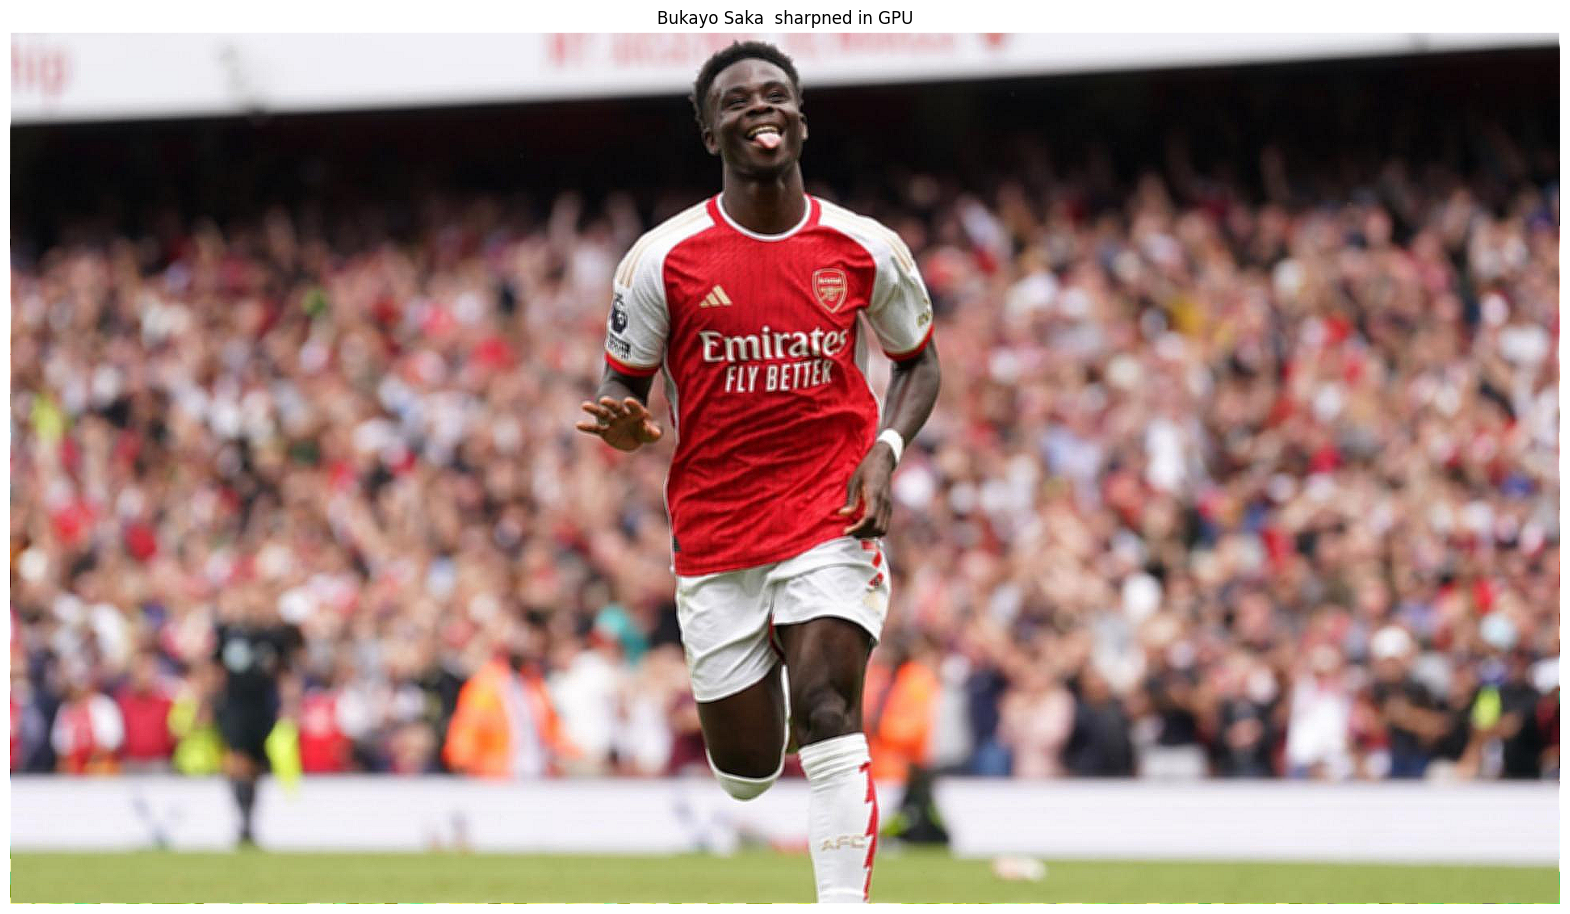

The matrix of Bukayo Saka is now is the sharpned matrix


In [13]:
#Show the blurred Bukayo Saka
axes= plt.Figure(figsize=(10,9))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka  sharpned in GPU")
ax.imshow(empty_sample_output)
plt.axis("off")
plt.show()
print("The matrix of Bukayo Saka is now is the sharpned matrix")

CPU sharpening time: 21.527570 seconds


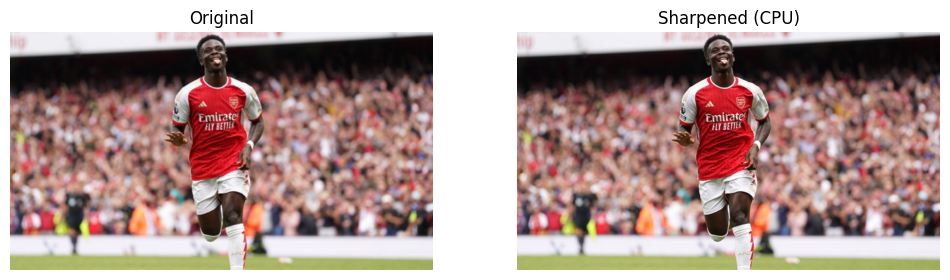

Saved 'saka_sharpen_cpu.png'


In [14]:
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# sharpening kernel
SHARPEN_K = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

def conv2d_rgb_sharpen_cpu(image, kernel=SHARPEN_K, padding='replicate'):
    """
    Convolve an HxWx3 uint8 RGB image with a 3x3 kernel (applied per channel).
    padding: 'zero' or 'replicate' (default).
    Returns an HxWx3 uint8 array.
    """
    if image.dtype != np.uint8:
        raise ValueError("Input image must be uint8")
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Input must be H x W x 3 RGB image")

    h, w, _ = image.shape
    out = np.zeros_like(image, dtype=np.uint8)
    img_f = image.astype(np.float32)
    pad = 1

    # build padded image
    if padding == 'zero':
        padded = np.zeros((h + 2*pad, w + 2*pad, 3), dtype=np.float32)
        padded[pad:pad+h, pad:pad+w, :] = img_f
    elif padding == 'replicate':
        padded = np.zeros((h + 2*pad, w + 2*pad, 3), dtype=np.float32)
        padded[pad:pad+h, pad:pad+w, :] = img_f
        # top/bottom
        padded[:pad, pad:pad+w, :] = img_f[0:1, :, :]
        padded[pad+h:, pad:pad+w, :] = img_f[h-1:h, :, :]
        # left/right (including corners)
        padded[:, :pad, :] = padded[:, pad:pad+1, :]
        padded[:, pad+w:, :] = padded[:, pad+w-1:pad+w, :]
    else:
        raise ValueError("padding must be 'zero' or 'replicate'")

    # For convolution (kernel flip), but kernel is symmetric here so flip is optional
    k = np.flipud(np.fliplr(kernel))

    # direct nested loops (simple and clear)
    for y in range(h):
        for x in range(w):
            region = padded[y:y+3, x:x+3, :]        # shape (3,3,3)
            res = (region * k[:, :, None]).sum(axis=(0,1))
            res = np.clip(res, 0, 255)
            out[y, x, :] = res.astype(np.uint8)

    return out

# Example usage
if __name__ == "__main__":
    path = "saka_blurred.jpg"   # place the image in working dir
    img = Image.open(path).convert("RGB")
    img_np = np.array(img)

    t0 = time.perf_counter()
    out = conv2d_rgb_sharpen_cpu(img_np, padding='replicate')
    t1 = time.perf_counter()
    print(f"CPU sharpening time: {t1 - t0:.6f} seconds")
    time_taken_cpu=t1 - t0

    # show results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_np); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(out);    ax[1].set_title("Sharpened (CPU)"); ax[1].axis("off")
    plt.show()

    # Image.fromarray(out).save("saka_sharpen_cpu.png")
    # print("Saved 'saka_sharpen_cpu.png'")

In [15]:
print(f"Time taken in GPU is {gpu_execution_time} \nTime taken in CPU is {time_taken_cpu}")

Time taken in GPU is 0.001535654067993164 
Time taken in CPU is 21.527569932000006
